In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

In [2]:
# CSVファイルから過去レートを読み込む
df = pd.read_csv("USDJPY_hourly2010_train.txt")

# データの最後尾を表示
print(df.tail())

# 最後の列にHIGHを追加
df_shift = df.copy()
df_shift['ANS'] = df['HIGH']
df_shift.ANS = df_shift.ANS.shift(-1)
 
# 改めてデータを確認
print("")
print(df_shift.tail())

# 最後の行を除外
df_shift = df_shift[:-1]
 
# 念のためデータをdf_2として新しいデータフレームへコピ−
df_2 = df_shift.copy()
 
# time（時間）を削除
del df_2['DTYYYYMMDD']
del df_2['TIME']
del df_2['TICKER']

# 改めてデータを確認
print("")
print(df_2.tail())

# データセットのサイズを確認
print("")
print("シェイプ[0]: ",df_2.shape[0])
print("シェイプ[1]: ",df_2.shape[1])

# データセットの行数と列数を格納
n = df_2.shape[0]
p = df_2.shape[1]

# 訓練データとテストデータへ切り分け
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = df_2.loc[np.arange(train_start, train_end), :]
data_test = df_2.loc[np.arange(test_start, test_end), :]

# データの正規化
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train_norm = scaler.transform(data_train)
data_test_norm = scaler.transform(data_test)

# 特徴量とターゲットへ切り分け
X_train = data_train_norm[:, 1:]
y_train = data_train_norm[:, 0]
X_test = data_test_norm[:, 1:]
y_test = data_test_norm[:, 0]

# 正規化から通常の値へ戻す
y_test = y_test.reshape(1237, 1)
test_inv = np.concatenate((y_test, X_test), axis=1)
test_inv = scaler.inverse_transform(test_inv)

# 正規化の前のテストデータ
print("")
print(data_test.values[0])
 
# 正規化後のテストデータ
print(y_test[0], X_test[0])
 
# 正規化から戻したデータ
print(test_inv[0])

      TICKER  DTYYYYMMDD    TIME   OPEN   HIGH    LOW  CLOSE
6183  USDJPY    20101231  170000  81.22  81.25  80.92  81.08
6184  USDJPY    20101231  180000  81.09  81.15  81.04  81.09
6185  USDJPY    20101231  190000  81.09  81.21  81.09  81.16
6186  USDJPY    20101231  200000  81.17  81.27  81.16  81.24
6187  USDJPY    20101231  210000  81.24  81.29  81.14  81.17

      TICKER  DTYYYYMMDD    TIME   OPEN   HIGH    LOW  CLOSE    ANS
6183  USDJPY    20101231  170000  81.22  81.25  80.92  81.08  81.15
6184  USDJPY    20101231  180000  81.09  81.15  81.04  81.09  81.21
6185  USDJPY    20101231  190000  81.09  81.21  81.09  81.16  81.27
6186  USDJPY    20101231  200000  81.17  81.27  81.16  81.24  81.29
6187  USDJPY    20101231  210000  81.24  81.29  81.14  81.17    NaN

       OPEN   HIGH    LOW  CLOSE    ANS
6182  81.30  81.31  81.21  81.21  81.25
6183  81.22  81.25  80.92  81.08  81.15
6184  81.09  81.15  81.04  81.09  81.21
6185  81.09  81.21  81.09  81.16  81.27
6186  81.17  81.27  81.1

In [3]:
# 訓練データの特徴量の数を取得
n_stocks = X_train.shape[1]
 
# ニューロンの数を設定
n_neurons_1 = 256
n_neurons_2 = 128
 
# セッションの開始
net = tf.InteractiveSession()
 
# プレースホルダーの作成
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])
 
# 初期化
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# 出力の重み
W_out = tf.Variable(weight_initializer([n_neurons_2, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# 隠れ層の設定（ReLU＝活性化関数）
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))

# 出力層の設定
out = tf.transpose(tf.add(tf.matmul(hidden_2, W_out), bias_out))

# 隠れ層の設定（ReLU＝活性化関数）
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
 
# 出力層の設定
out = tf.transpose(tf.add(tf.matmul(hidden_2, W_out), bias_out))

# コスト関数
mse = tf.reduce_mean(tf.squared_difference(out, Y))
 
# 最適化関数
opt = tf.train.AdamOptimizer().minimize(mse)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# 初期化
net.run(tf.global_variables_initializer())

# ニューラルネットワークの設定
batch_size = 128
mse_train = []
mse_test = []
 
# 訓練開始！500回の反復処理
epochs = 500
for e in range(epochs):
    net.run(opt, feed_dict={X: X_train, Y: y_train})

In [5]:
# テストデータで予測
pred_test = net.run(out, feed_dict={X: X_test})
 
# 予測データの最初の2つを表示
pred_test[0][0:2]

# 予測値をテストデータに戻そう（値も正規化からインバース）
pred_test = np.concatenate((pred_test.T, X_test), axis=1)
pred_inv = scaler.inverse_transform(pred_test)
 
# 元データの最後尾
df_shift.tail(1)

,TICKER,DTYYYYMMDD,TIME,OPEN,HIGH,LOW,CLOSE,ANS
6186,USDJPY,20101231,200000,81.17,81.27,81.16,81.24,81.29


In [6]:
# テストデータの最後のデータ（正規化前）
print(data_test.values[98])
 
# テストデータの最後のデータ（正規化を戻した後）
print(test_inv[98])
 
# モデルが予測したデータ
print(pred_inv[98])

[81.38 81.43 81.31 81.32 81.42]
[81.38 81.43 81.31 81.32 81.42]
[81.39394623 81.43       81.31       81.32       81.42      ]


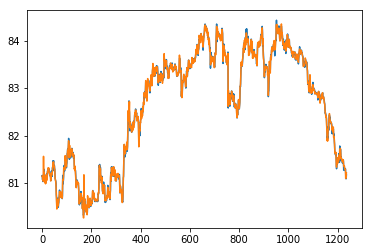

In [7]:
# 予測と実際のテストの終値のチャートをプロットしてみよう
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(test_inv[:,0])
line2, = ax1.plot(pred_inv[:,0])
plt.show()

array([ 0.71347113,  0.68781183,  0.70919458, ..., -1.        ,
       -0.96863863, -0.98574483])